# Karpathy Net - Learn without a class (forgot class)


* **Author** : Yalla Mahanth
* **SR No** : 24004

### imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset

import os
import tqdm
import math
import json
import pickle
import pynvml
import argparse
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime as dt
import matplotlib.gridspec as gridspec

def get_best_gpu(verbose = False):
    pynvml.nvmlInit()
    num_gpus = torch.cuda.device_count()

    if num_gpus == 0:
        if verbose :
            print("[!] No CUDA devices found, running on CPU.")
        return 'cpu'

    gpu_mem = []
    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        free_mem = mem_info.free
        total_mem = mem_info.total
        if verbose:
            print(f"[+] GPU {i}: Total {total_mem / 1e9:.2f} GB, Free {free_mem / 1e9:.2f} GB")
        gpu_mem.append((i, free_mem))

    gpu_mem.sort(key=lambda x: x[1], reverse=True)

    best_gpu = gpu_mem[0][0]
    second_best_gpu = gpu_mem[1][0] if len(gpu_mem) > 1 else best_gpu

    selected_gpu = second_best_gpu if best_gpu == 0 else best_gpu

    pynvml.nvmlShutdown()
    return selected_gpu

def set_gpu(manual_set = None, verbose = False):
    device_active = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device_active == 'cuda':
        if verbose:
            print('[+] CUDA : available')
        try:
            if manual_set is not None:
                GPU_NUMBER = manual_set
            else:
                GPU_NUMBER = get_best_gpu(verbose)
            if verbose:
                print(f'[>] Current Device {torch.cuda.current_device()} -> changing it to {GPU_NUMBER}')
            torch.cuda.set_device(GPU_NUMBER)
            if verbose:
                print(f'[+] Current Device {torch.cuda.current_device()}')
        except Exception as e:
            if verbose:
                print(f'[-] Error Occured while changing GPU ! \n\n\tERROR :{e}\n\n')
                print(f'[!] CUDA ERR : Couldn\'t change  -> using CPU {device_active = }')
        finally: 
            pass
        print(f'[>] device = cuda:{GPU_NUMBER}')
    else :
        if verbose:
            print(f'[!] CUDA ERR : Not available -> using CPU {device_active = }')
        print(f'[>] device = cpu')


In [7]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Cifar 10 Dataset

In [8]:
root_ = './'
cifar_data_folder = f'{root_}data/cifar10/'

cifar_train_batch_1_file = cifar_data_folder + 'data_batch_1'
cifar_train_batch_2_file = cifar_data_folder + 'data_batch_2'
cifar_train_batch_3_file = cifar_data_folder + 'data_batch_3'
cifar_train_batch_4_file = cifar_data_folder + 'data_batch_4'
cifar_train_batch_5_file = cifar_data_folder + 'data_batch_5'
cifar_test_file = cifar_data_folder + 'test_batch' 
cifar_meta_data = cifar_data_folder + 'batches.meta' 

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_batch_1 = unpickle(cifar_train_batch_1_file) 
cifar_batch_2 = unpickle(cifar_train_batch_2_file)
cifar_batch_3 = unpickle(cifar_train_batch_3_file)
cifar_batch_4 = unpickle(cifar_train_batch_4_file)
cifar_batch_5 = unpickle(cifar_train_batch_5_file)
cifar_batch_test = unpickle(cifar_test_file)
batches_meta = unpickle(cifar_meta_data)

cifar_batch_1_data = cifar_batch_1[b'data']
cifar_batch_1_labels = np.array(cifar_batch_1[b'labels'])
cifar_batch_2_data = cifar_batch_2[b'data']
cifar_batch_2_labels = np.array(cifar_batch_2[b'labels'])
cifar_batch_3_data = cifar_batch_3[b'data']
cifar_batch_3_labels = np.array(cifar_batch_3[b'labels'])
cifar_batch_4_data = cifar_batch_4[b'data']
cifar_batch_4_labels = np.array(cifar_batch_4[b'labels'])
cifar_batch_5_data = cifar_batch_5[b'data']
cifar_batch_5_labels = np.array(cifar_batch_5[b'labels'])

cifar_batch_test_data = cifar_batch_test[b'data']
cifar_batch_test_labels = np.array(cifar_batch_test[b'labels'])

cifar_train_data = np.vstack([cifar_batch_1_data, cifar_batch_2_data, cifar_batch_3_data,cifar_batch_4_data, cifar_batch_5_data]).reshape(-1,32*32*3)
cifar_train_labels = np.hstack([cifar_batch_1_labels, cifar_batch_2_labels, cifar_batch_3_labels,cifar_batch_4_labels, cifar_batch_5_labels])

cifar_test_data = cifar_batch_test_data.reshape(-1,32*32*3)
cifar_test_labels = cifar_batch_test_labels

labels = np.unique(cifar_train_labels)

cifar_label_dict = {}
for i, label in enumerate(labels):
    cifar_label_dict[label] = batches_meta[b'label_names'][i].decode('utf-8')


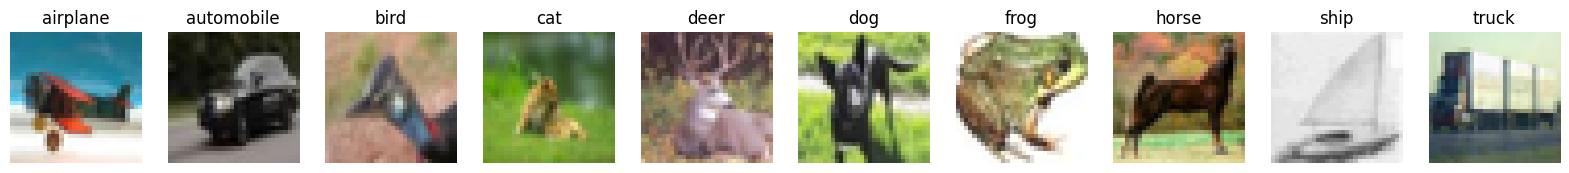

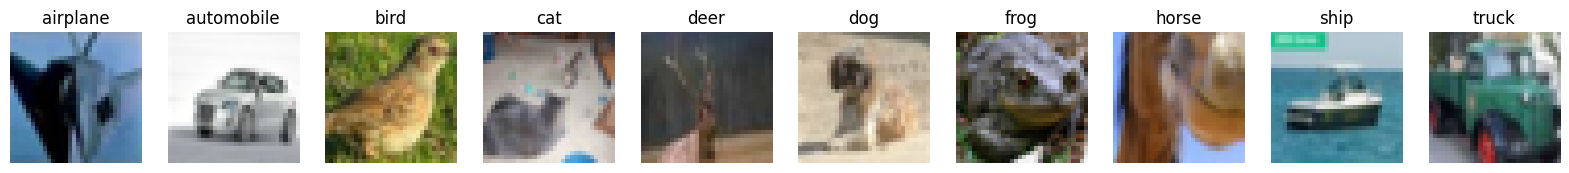

In [9]:
def plot_cifar(X,y,n = 10):
    plt.figure(figsize = (20,10))
    for i in range(n):
        mask = y == i 
        X_ = X[mask]
        y_ = y[mask]
        idx = np.random.randint(0,X_.shape[0])
        plt.subplot(1,n,i+1)
        plt.imshow(X_[idx].reshape(3,32,32).transpose(1,2,0))
        plt.title(cifar_label_dict[y_[idx]])
        plt.axis('off')
    plt.show()
plot_cifar(cifar_train_data,cifar_train_labels)
plot_cifar(cifar_train_data,cifar_train_labels)

In [11]:
forget_class = 7
def train_test_split(X,y,test_size = 0.2 , shuffle = True):
    if shuffle:
        mask = np.random.permutation(len(y))
        X = X[mask]
        y = y[mask]
    split = len(y) - int(len(y) * test_size)
    return X[:split],y[:split],X[split:],y[split:]

def remove_class(X,y,forget_class = 10):
    mask = y != forget_class
    return X[mask],y[mask]

cifar_train_data, cifar_train_labels = remove_class(cifar_train_data, cifar_train_labels, forget_class)
Xtr,  ytr, Xval, yval = train_test_split(cifar_train_data, cifar_train_labels, test_size=0.2)
Xte , yte = cifar_test_data, cifar_test_labels
label_dict = cifar_label_dict

In [12]:
Xtr = torch.tensor(Xtr , dtype = torch.float32)
ytr = torch.tensor(ytr , dtype = torch.float32)
Xval = torch.tensor(Xval , dtype = torch.float32)
yval = torch.tensor(yval , dtype = torch.float32)
Xte = torch.tensor(Xte , dtype = torch.float32)
yte = torch.tensor(yte , dtype = torch.float32)

In [13]:
ytr_enc = torch.zeros(ytr.shape[0] , len(labels)) 
yval_enc = torch.zeros(yval.shape[0] , len(labels))
yte_enc = torch.zeros(yte.shape[0] , len(labels))

ytr_enc[torch.arange(ytr.shape[0]) , ytr.long()] = 1
yval_enc[torch.arange(yval.shape[0]) , yval.long()] = 1
yte_enc[torch.arange(yte.shape[0]) , yte.long()] = 1

In [14]:
Xtr.shape, ytr.shape, ytr_enc.shape

(torch.Size([36000, 3072]), torch.Size([36000]), torch.Size([36000, 10]))

In [15]:
Xtr[0].reshape((3,32,32)).shape , ytr_enc[0].shape 

(torch.Size([3, 32, 32]), torch.Size([10]))

### Cifar Dataset Loader

In [17]:
class DatasetCifar(Dataset):
    def __init__(self , X , y , labels, device = 'cpu', img_shape = (3,32,32)):
        # self.X , self.y = self.augmentation(X , y, pixels=2)
        self.X,self.y = X, y
        self.labels = torch.sort(torch.tensor(labels))
        self.n_classes = len(labels)
        self.each_img_shape = img_shape
        self.device = device
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self , idx):
        pixs = np.random.randint(1,4)
        X_i = self.random_agumentation(self.X[idx] ,  pixels = pixs)
        y_i = F.one_hot(self.y[idx].long() , num_classes = self.n_classes).float()
        
        if self.device == 'cuda':
            X_i = X_i.cuda()
            y_i = y_i.cuda()
        
        return X_i , y_i
        
    def augmentation(self, Xb, yb, pixels = 1):
        X_Right_shifted = torch.roll(Xb , shifts = pixels , dims = 2)
        X_Left_shifted = torch.roll(Xb , shifts = -pixels , dims = 2)
        X_Up_shifted = torch.roll(Xb , shifts = pixels , dims = 1)        
        X_Down_shifted = torch.roll(Xb , shifts = -pixels , dims = 1)

        X_NE_Shifted = torch.roll(X_Right_shifted , shifts = pixels , dims = 1)
        X_NW_Shifted = torch.roll(X_Left_shifted , shifts = pixels , dims = 1)
        
        X_SE_Shifted = torch.roll(X_Right_shifted , shifts = -pixels , dims = 1)
        X_SW_Shifted = torch.roll(X_Left_shifted , shifts = -pixels , dims = 1)
        
        X_shifted = torch.cat([Xb, X_Right_shifted , X_Left_shifted , X_Up_shifted , X_Down_shifted , X_NE_Shifted , X_NW_Shifted , X_SE_Shifted , X_SW_Shifted] , dim = 0)
        y_shifted = torch.cat([yb, yb , yb , yb , yb , yb , yb , yb , yb] , dim = 0)
        return X_shifted , y_shifted
    
    def random_agumentation(self , X_i , pixels = 1):
        X_i = X_i.reshape(self.each_img_shape)
        type = np.random.randint(1,19) # half of the time : original
        if type == 1:
            X_Right_shifted = torch.roll(X_i , shifts = pixels , dims = 2)
            X_shifted = X_Right_shifted
        elif type == 2:
            X_Left_shifted = torch.roll(X_i , shifts = -pixels , dims = 2)
            X_shifted = X_Left_shifted
        elif type == 3:
            X_Up_shifted = torch.roll(X_i , shifts = pixels , dims = 1)
            X_shifted = X_Up_shifted
        elif type == 4:
            X_Down_shifted = torch.roll(X_i , shifts = -pixels , dims = 1)
            X_shifted = X_Down_shifted
        elif type == 5:
            X_Right_shifted = torch.roll(X_i , shifts = pixels , dims = 2)
            X_shifted = torch.roll(X_Right_shifted , shifts = pixels , dims = 1)
        elif type == 6:
            X_Left_shifted = torch.roll(X_i , shifts = -pixels , dims = 2)
            X_shifted = torch.roll(X_Left_shifted , shifts = -pixels , dims = 1)
        elif type == 7:
            X_Up_shifted = torch.roll(X_i , shifts = pixels , dims = 1)
            X_shifted = torch.roll(X_Up_shifted , shifts = -pixels , dims = 2)
        elif type == 8:
            X_Down_shifted = torch.roll(X_i , shifts = -pixels , dims = 1)
            X_shifted = torch.roll(X_Down_shifted , shifts = pixels , dims = 2)
        elif type == 9:
            X_flip = torch.flip(X_i , dims = [-1]) 
            X_shifted = X_flip
        else :
            X_shifted = X_i
        
        return X_shifted 
    
train_dataset = DatasetCifar(Xtr , ytr, labels)
len(train_dataset)

36000

In [18]:
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
Xb, yb = next(iter(dataloader))
Xb.shape, yb.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 10]))

### helper functions

In [19]:
def plot_img(Xb , yb):
    idx = np.random.randint(0,Xb.shape[0])
    plt.figure(figsize = (2,2))
    plt.imshow(Xb[idx].cpu().numpy().astype(np.uint8).reshape(3,32,32).transpose(1,2,0))
    plt.title(cifar_label_dict[yb[idx].argmax().item()])
    plt.axis('off')
    plt.show()

In [20]:
def plot_probs(sf_probs ,label_dict = cifar_label_dict , k = 5):
    plt.figure(figsize=(5, 2))
    sorted_indices = torch.argsort(sf_probs, descending=True)
    sorted_probs = sf_probs[sorted_indices]
    sorted_labels = [label_dict[i.item()] for i in sorted_indices]

    plt.barh(sorted_labels[:k], sorted_probs.cpu().detach().numpy()[:k])
    plt.xlabel('Probability')
    plt.ylabel('Class')
    plt.title('Top 5 Softmax Probabilities')
    plt.gca().invert_yaxis()
    plt.show()

In [21]:
def plot_img_with_probs(Xb, yb, model, label_dict=cifar_label_dict, k=5):
    idx = np.random.randint(0, Xb.shape[0]) 
    
    img = Xb[idx].cpu().numpy().astype(np.uint8).reshape(3, 32, 32).transpose(1, 2, 0)
    true_label_idx = yb[idx].argmax().item()
    true_label = cifar_label_dict[true_label_idx]
    
    outputs = model(Xb[idx].unsqueeze(0))
    sf_probs = F.softmax(outputs, dim=1)
    
    sorted_indices = torch.argsort(sf_probs[0], descending=True)
    sorted_probs = sf_probs[0][sorted_indices]
    sorted_labels = [label_dict[i.item()] for i in sorted_indices]
    colors = ['green' if sorted_indices[i].item() == true_label_idx else 'red' for i in range(k)]

    fig = plt.figure(figsize=(6, 2))  
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1]) 

    ax0 = plt.subplot(gs[0])
    ax0.imshow(img)
    ax0.set_title(f"Label: {true_label}")
    ax0.axis('off')
    ax1 = plt.subplot(gs[1:])
    ax1.barh(sorted_labels[:k], sorted_probs.cpu().detach().numpy()[:k], color=colors)
    ax1.set_xlabel('Probability')
    ax1.set_title('Top 5 Predictions')
    ax1.invert_yaxis()

    plt.tight_layout()
    plt.show()

def plot_img_with_probs_bottom(Xb, yb, model, label_dict=cifar_label_dict, k=5):
    idx = np.random.randint(0, Xb.shape[0])

    img = Xb[idx].cpu().numpy().astype(np.uint8).reshape(3, 32, 32).transpose(1, 2, 0)
    true_label_idx = yb[idx].argmax().item()  
    true_label = cifar_label_dict[true_label_idx] 
    
    outputs = model(Xb[idx].unsqueeze(0))
    sf_probs = F.softmax(outputs, dim=1)
    
    sorted_indices = torch.argsort(sf_probs[0], descending=True)
    sorted_probs = sf_probs[0][sorted_indices]
    sorted_labels = [label_dict[i.item()] for i in sorted_indices]

    colors = ['green' if sorted_indices[i].item() == true_label_idx else 'red' for i in range(k)]

    fig, axes = plt.subplots(2, 1, figsize=(3,5), gridspec_kw={'height_ratios': [2, 1]})

    axes[0].imshow(img)
    axes[0].set_title(f"Label: {true_label}")
    axes[0].axis('off')

    axes[1].barh(sorted_labels[:k], sorted_probs.cpu().detach().numpy()[:k], color=colors)
    axes[1].set_xlabel('Probability')
    axes[1].set_title('Top 5 Predictions')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

def compare_with_images(model, Xte, yte, lables = 10):
    fig = plt.figure(figsize=(20,2))
    for i in range(10):
        ax = fig.add_subplot(1, lables, i+1)
        imgs = Xte[yte == i]
        img_i = np.random.randint(imgs.shape[0])
        model_pred = model.predict(imgs[img_i])
        lbls = yte[yte == i]
        
        ax.imshow(imgs[img_i].cpu().numpy().astype(np.uint8).reshape(3,32,32).transpose(1,2,0), cmap='gray')
        
        if model_pred[0] == lbls[img_i]:
            ax.set_title(f'Actual :{int(lbls[img_i])} \nPredict :{int(model_pred[0])} $\\checkmark$ \n{cifar_label_dict[int(lbls[img_i])]}:', color='green')
        else:
            ax.set_title(f'Actual :{int(lbls[img_i])} \nPredict :{int(model_pred[0])} $\\times$ \n{cifar_label_dict[int(lbls[img_i])]}:', color='red')
        
        ax.axis('off')

In [22]:
def save_checkpoint(model, optimiser, epoch, logs, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimiser_state_dict': optimiser.state_dict(),
        'logs': logs
    }
    torch.save(checkpoint, filename)
    print(f"[+] Checkpoint saved at epoch {epoch}")
    


In [23]:
def load_checkpoint(model, optimiser, filename="checkpoint.pth"):
    checkpoint = torch.load(filename, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
    epoch = checkpoint['epoch']
    logs = checkpoint['logs']
    print(f"[+] Checkpoint loaded. Resuming from epoch {epoch}")
    return epoch, logs

# Karpathy Class

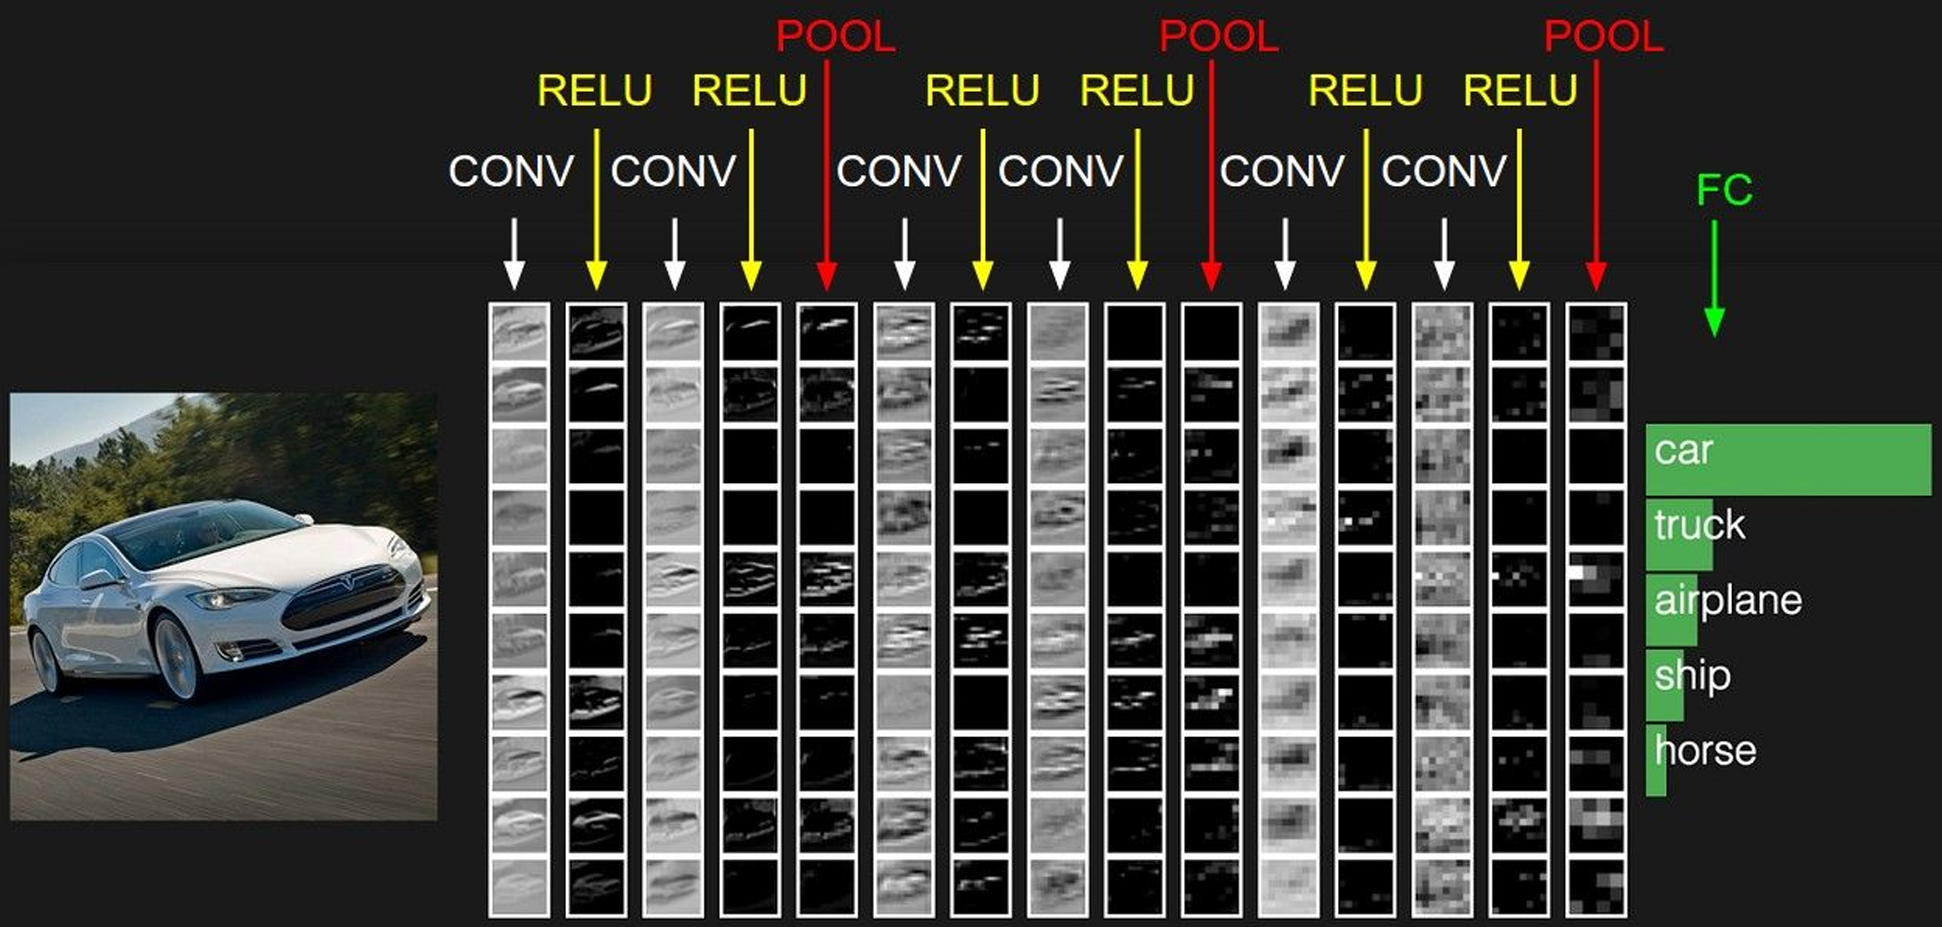

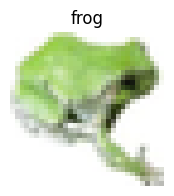

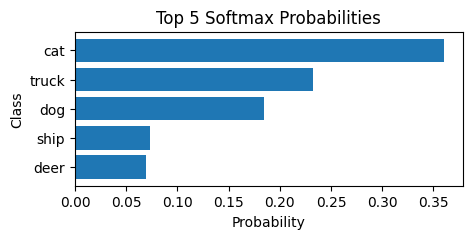

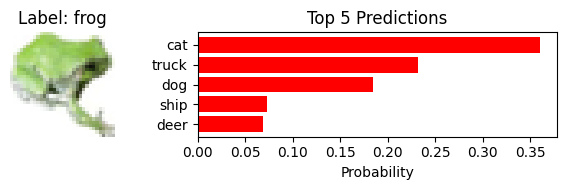

In [ ]:
class KarpathyNet(nn.Module):
    
    def __init__(self, inp_size, filters, filter_sizes, strides, paddings , num_classes):
        super(KarpathyNet,self).__init__() 
        
        self.conv11 = nn.Conv2d(inp_size, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.conv12 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv21 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.conv22 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv31 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.conv32 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc_input = 4*4*filters
        self.fc1 = nn.Linear(self.fc_input, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool1(x)
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.pool2(x)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = self.pool3(x)
        x = x.view(-1, self.fc_input)
        x = self.fc1(x)
        return x
    
    def predict_proba(self, x):
        x = self.forward(x)
        return F.softmax(x, dim = -1)

    def predict(self, x):
        x = self.predict_proba(x)
        return torch.argmax(x, dim = -1)
    
    def accuracy(self, x, y):
        y_pred = self.predict(x)
        return (y_pred == y).float().mean()
    
dataset = DatasetCifar(Xtr , ytr , device = device)
Xb, yb = next(iter(dataloader))
model = KarpathyNet(3,16, 5,1,2, len(labels))
if device == 'cuda':
    model = model.cuda()
    Xb = Xb.cuda()
    yb = yb.cuda()
out = model(Xb)
sf_probs = torch.softmax(out[0] , dim = 0)
plot_img(Xb[:1] , yb[:1])
plot_probs(sf_probs)
plot_img_with_probs(Xb[:1], yb[:1], model)

In [ ]:
class NetTrainer():
    
    def __init__(self, model, optimiser, criterion, train_dataset_loader,valid_dataset_loader,device = 'cpu'):
        self.model = model
        self.optimiser = optimiser
        self.criterion = criterion
        self.train_dataset_loader = train_dataset_loader
        self.valid_dataset_loader = valid_dataset_loader
        self.logs = {
            'train_epochs':[],
            'train_loss':[], 
            'valid_epochs':[],
            'valid_loss':[]
            }
        if device == 'cuda':
            self.model = self.model.cuda()
            print('[+] Model is moved to GPU')
        
    def train(self, n_epochs, validate_every = 10):
        for epoch in range(n_epochs):
            train_loss = self.training(epoch , n_epochs)
            self.logs['train_loss'].append(train_loss)
            self.logs['train_epochs'].append(epoch)
            if epoch == 0 or (epoch + 1) % validate_every == 0:
                valid_loss = self.validation(epoch , n_epochs)
                self.logs['valid_loss'].append(valid_loss)
                self.logs['valid_epochs'].append(epoch)
                print(f'Epoch {epoch+1:5d}/{n_epochs:5d} | Train Loss: {train_loss:.7f} | Valid Loss: {valid_loss:.7f}')
            else :
                print(f'Epoch {epoch+1:5d}/{n_epochs:5d} | Train Loss: {train_loss:.7f}')
    
    def training(self, epoch, n_epochs):
        self.model.train()
        total_loss = 0.0
        for Xb, yb in tqdm(self.train_dataset_loader, desc=f"Training Epoch {epoch+1}/{n_epochs}", unit='batch'):
            y_pred = self.model(Xb)
            loss = self.criterion(y_pred, yb)
            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()
            total_loss += loss.item()
        return total_loss / len(self.train_dataset_loader)
   
    def validation(self, epoch, n_epochs):
        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for Xb, yb in tqdm(self.valid_dataset_loader, desc=f"Validation Epoch {epoch+1}/{n_epochs}", unit='batch'):
                y_pred = self.model(Xb)
                loss = self.criterion(y_pred, yb)
                total_loss += loss.item()
        return total_loss / len(self.valid_dataset_loader)
    
    def plot_losses(self):
        plt.figure(figsize=(10,5))
        plt.plot(self.logs['train_epochs'], self.logs['train_loss'], label='Train Loss')
        plt.plot(self.logs['valid_epochs'], self.logs['valid_loss'], label='Valid Loss')
        plt.legend()
        plt.show()
    
    def accuracy(self, X, y):
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model.predict(X)
            return (y_pred == y).float().mean()
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.model.predict(X)

### Training

In [ ]:
model = KarpathyNet(3,16,5,1,2, len(labels))
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')
optimiser = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_dataset = DatasetCifar(Xtr , ytr , device = device)
valid_dataset = DatasetCifar(Xval , yval , device = device)

train_dataset_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataset_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

trainer = NetTrainer(model, optimiser, criterion, train_dataset_loader, valid_dataset_loader , device = device)

Total number of parameters: 35866
[+] Model is moved to GPU


In [59]:
Xtr = Xtr.view(-1,3,32,32)
Xval = Xval.view(-1,3,32,32)
Xte = Xte.view(-1,3,32,32)

In [60]:
if device == 'cuda':
    Xtr = Xtr.cuda()
    Xval = Xval.cuda()
    Xte = Xte.cuda()
    ytr_enc = ytr_enc.cuda()
    yval_enc = yval_enc.cuda()
    yte_enc = yte_enc.cuda()
    ytr = ytr.cuda()
    yval = yval.cuda()
    yte = yte.cuda()    

In [61]:
before_training_acc = trainer.accuracy(Xval, yval)
print(f'Accuracy before training: {before_training_acc:.2%}')

Accuracy before training: 11.79%


In [62]:
time_start = dt.now()

number_of_epochs = 100
number_of_valids = 5

validate_epochs = number_of_epochs // number_of_valids

trainer.train(n_epochs=number_of_epochs, validate_every=validate_epochs)
print(f'[>] Training time: {dt.now() - time_start}')

Validation Epoch 1/100: 100%|██████████| 125/125 [00:01<00:00, 98.56batch/s]


Epoch     1/  100 | Train Loss: 1.7782024 | Valid Loss: 1.5577983


Training Epoch 2/100: 100%|██████████| 500/500 [00:07<00:00, 67.60batch/s]


Epoch     2/  100 | Train Loss: 1.4817146


Training Epoch 3/100: 100%|██████████| 500/500 [00:07<00:00, 69.34batch/s]


Epoch     3/  100 | Train Loss: 1.3440666


Training Epoch 4/100: 100%|██████████| 500/500 [00:07<00:00, 69.38batch/s]


Epoch     4/  100 | Train Loss: 1.2540643


Training Epoch 5/100: 100%|██████████| 500/500 [00:07<00:00, 66.55batch/s]


Epoch     5/  100 | Train Loss: 1.1872763


Training Epoch 6/100: 100%|██████████| 500/500 [00:07<00:00, 63.70batch/s]


Epoch     6/  100 | Train Loss: 1.1358179


Training Epoch 7/100: 100%|██████████| 500/500 [00:07<00:00, 68.35batch/s]


Epoch     7/  100 | Train Loss: 1.1023701


Training Epoch 8/100: 100%|██████████| 500/500 [00:07<00:00, 67.92batch/s]


Epoch     8/  100 | Train Loss: 1.0654092


Training Epoch 9/100: 100%|██████████| 500/500 [00:07<00:00, 71.18batch/s]


Epoch     9/  100 | Train Loss: 1.0409266


Training Epoch 10/100: 100%|██████████| 500/500 [00:07<00:00, 69.17batch/s]


Epoch    10/  100 | Train Loss: 1.0110774


Training Epoch 11/100: 100%|██████████| 500/500 [00:07<00:00, 68.94batch/s]


Epoch    11/  100 | Train Loss: 1.0079297


Training Epoch 12/100: 100%|██████████| 500/500 [00:07<00:00, 70.93batch/s]


Epoch    12/  100 | Train Loss: 0.9789380


Training Epoch 13/100: 100%|██████████| 500/500 [00:06<00:00, 73.37batch/s]


Epoch    13/  100 | Train Loss: 0.9710460


Training Epoch 14/100: 100%|██████████| 500/500 [00:06<00:00, 77.15batch/s]


Epoch    14/  100 | Train Loss: 0.9504045


Training Epoch 15/100: 100%|██████████| 500/500 [00:06<00:00, 74.86batch/s]


Epoch    15/  100 | Train Loss: 0.9439304


Training Epoch 16/100: 100%|██████████| 500/500 [00:07<00:00, 65.90batch/s]


Epoch    16/  100 | Train Loss: 0.9395782


Training Epoch 17/100: 100%|██████████| 500/500 [00:07<00:00, 68.21batch/s]


Epoch    17/  100 | Train Loss: 0.9296899


Training Epoch 18/100: 100%|██████████| 500/500 [00:07<00:00, 64.53batch/s]


Epoch    18/  100 | Train Loss: 0.9143787


Training Epoch 19/100: 100%|██████████| 500/500 [00:06<00:00, 72.27batch/s]


Epoch    19/  100 | Train Loss: 0.9061601


Training Epoch 20/100: 100%|██████████| 500/500 [00:07<00:00, 70.58batch/s]


Epoch    20/  100 | Train Loss: 0.8911011


Training Epoch 21/100: 100%|██████████| 500/500 [00:06<00:00, 74.82batch/s]


Epoch    21/  100 | Train Loss: 0.8972697


Training Epoch 22/100: 100%|██████████| 500/500 [00:06<00:00, 76.97batch/s]


Epoch    22/  100 | Train Loss: 0.8844284


Training Epoch 23/100: 100%|██████████| 500/500 [00:06<00:00, 74.25batch/s]


Epoch    23/  100 | Train Loss: 0.8850855


Training Epoch 24/100: 100%|██████████| 500/500 [00:06<00:00, 75.82batch/s]


Epoch    24/  100 | Train Loss: 0.8792506


Training Epoch 25/100: 100%|██████████| 500/500 [00:06<00:00, 75.91batch/s]


Epoch    25/  100 | Train Loss: 0.8665890


Training Epoch 26/100: 100%|██████████| 500/500 [00:06<00:00, 72.89batch/s]


Epoch    26/  100 | Train Loss: 0.8747320


Training Epoch 27/100: 100%|██████████| 500/500 [00:06<00:00, 79.35batch/s]


Epoch    27/  100 | Train Loss: 0.8677612


Training Epoch 28/100: 100%|██████████| 500/500 [00:06<00:00, 76.47batch/s]


Epoch    28/  100 | Train Loss: 0.8633013


Training Epoch 29/100: 100%|██████████| 500/500 [00:06<00:00, 80.47batch/s]


Epoch    29/  100 | Train Loss: 0.8547825


Training Epoch 30/100: 100%|██████████| 500/500 [00:06<00:00, 77.93batch/s]


Epoch    30/  100 | Train Loss: 0.8579082


Training Epoch 31/100: 100%|██████████| 500/500 [00:06<00:00, 76.33batch/s]


Epoch    31/  100 | Train Loss: 0.8561746


Training Epoch 32/100: 100%|██████████| 500/500 [00:06<00:00, 74.65batch/s]


Epoch    32/  100 | Train Loss: 0.8621909


Training Epoch 33/100: 100%|██████████| 500/500 [00:07<00:00, 70.68batch/s]


Epoch    33/  100 | Train Loss: 0.8458196


Training Epoch 34/100: 100%|██████████| 500/500 [00:06<00:00, 76.29batch/s]


Epoch    34/  100 | Train Loss: 0.8516141


Training Epoch 35/100: 100%|██████████| 500/500 [00:06<00:00, 71.94batch/s]


Epoch    35/  100 | Train Loss: 0.8387732


Training Epoch 36/100: 100%|██████████| 500/500 [00:06<00:00, 75.64batch/s]


Epoch    36/  100 | Train Loss: 0.8364560


Training Epoch 37/100: 100%|██████████| 500/500 [00:06<00:00, 73.07batch/s]


Epoch    37/  100 | Train Loss: 0.8294390


Training Epoch 38/100: 100%|██████████| 500/500 [00:06<00:00, 74.87batch/s]


Epoch    38/  100 | Train Loss: 0.8215273


Training Epoch 39/100: 100%|██████████| 500/500 [00:06<00:00, 74.06batch/s]


Epoch    39/  100 | Train Loss: 0.8271111


Training Epoch 40/100: 100%|██████████| 500/500 [00:06<00:00, 75.92batch/s]


Epoch    40/  100 | Train Loss: 0.8204425


Training Epoch 41/100: 100%|██████████| 500/500 [00:07<00:00, 70.73batch/s]


Epoch    41/  100 | Train Loss: 0.8218490


Training Epoch 42/100: 100%|██████████| 500/500 [00:06<00:00, 75.32batch/s]


Epoch    42/  100 | Train Loss: 0.8343697


Training Epoch 43/100: 100%|██████████| 500/500 [00:06<00:00, 73.39batch/s]


Epoch    43/  100 | Train Loss: 0.8154807


Training Epoch 44/100: 100%|██████████| 500/500 [00:07<00:00, 69.46batch/s]


Epoch    44/  100 | Train Loss: 0.8170263


Training Epoch 45/100: 100%|██████████| 500/500 [00:07<00:00, 64.84batch/s]


Epoch    45/  100 | Train Loss: 0.8100619


Training Epoch 46/100: 100%|██████████| 500/500 [00:06<00:00, 75.62batch/s]


Epoch    46/  100 | Train Loss: 0.8028529


Training Epoch 47/100: 100%|██████████| 500/500 [00:07<00:00, 71.12batch/s]


Epoch    47/  100 | Train Loss: 0.8124552


Training Epoch 48/100: 100%|██████████| 500/500 [00:07<00:00, 63.03batch/s]


Epoch    48/  100 | Train Loss: 0.8034718


Training Epoch 49/100: 100%|██████████| 500/500 [00:07<00:00, 70.42batch/s]


Epoch    49/  100 | Train Loss: 0.8107642


Validation Epoch 50/100: 100%|██████████| 125/125 [00:01<00:00, 95.85batch/s]


Epoch    50/  100 | Train Loss: 0.8208615 | Valid Loss: 0.9662061


Training Epoch 51/100: 100%|██████████| 500/500 [00:07<00:00, 70.42batch/s]


Epoch    51/  100 | Train Loss: 0.8026773


Training Epoch 52/100: 100%|██████████| 500/500 [00:07<00:00, 64.24batch/s]


Epoch    52/  100 | Train Loss: 0.7994880


Training Epoch 53/100: 100%|██████████| 500/500 [00:07<00:00, 67.96batch/s]


Epoch    53/  100 | Train Loss: 0.7987383


Training Epoch 54/100: 100%|██████████| 500/500 [00:06<00:00, 73.92batch/s]


Epoch    54/  100 | Train Loss: 0.7919802


Training Epoch 55/100: 100%|██████████| 500/500 [00:06<00:00, 80.43batch/s]


Epoch    55/  100 | Train Loss: 0.7887864


Training Epoch 56/100: 100%|██████████| 500/500 [00:06<00:00, 76.95batch/s]


Epoch    56/  100 | Train Loss: 0.7913132


Training Epoch 57/100: 100%|██████████| 500/500 [00:17<00:00, 28.23batch/s]


Epoch    57/  100 | Train Loss: 0.7955674


Training Epoch 58/100: 100%|██████████| 500/500 [00:11<00:00, 42.42batch/s]


Epoch    58/  100 | Train Loss: 0.7844376


Training Epoch 59/100: 100%|██████████| 500/500 [00:06<00:00, 73.51batch/s]


Epoch    59/  100 | Train Loss: 0.7921952


Training Epoch 60/100: 100%|██████████| 500/500 [00:12<00:00, 41.43batch/s]


Epoch    60/  100 | Train Loss: 0.7953502


Training Epoch 61/100: 100%|██████████| 500/500 [00:20<00:00, 24.58batch/s]


Epoch    61/  100 | Train Loss: 0.7835363


Training Epoch 62/100: 100%|██████████| 500/500 [00:24<00:00, 20.23batch/s]


Epoch    62/  100 | Train Loss: 0.7882620


Training Epoch 63/100: 100%|██████████| 500/500 [00:19<00:00, 25.21batch/s]


Epoch    63/  100 | Train Loss: 0.7831651


Training Epoch 64/100: 100%|██████████| 500/500 [00:14<00:00, 34.13batch/s]


Epoch    64/  100 | Train Loss: 0.7929543


Training Epoch 65/100: 100%|██████████| 500/500 [00:13<00:00, 38.04batch/s]


Epoch    65/  100 | Train Loss: 0.7812130


Training Epoch 66/100: 100%|██████████| 500/500 [00:14<00:00, 34.33batch/s]


Epoch    66/  100 | Train Loss: 0.7921007


Training Epoch 67/100: 100%|██████████| 500/500 [00:15<00:00, 31.33batch/s]


Epoch    67/  100 | Train Loss: 0.7845744


Training Epoch 68/100: 100%|██████████| 500/500 [00:16<00:00, 30.21batch/s]


Epoch    68/  100 | Train Loss: 0.7721856


Training Epoch 69/100: 100%|██████████| 500/500 [00:15<00:00, 33.08batch/s]


Epoch    69/  100 | Train Loss: 0.7738736


Training Epoch 70/100: 100%|██████████| 500/500 [00:13<00:00, 36.83batch/s]


Epoch    70/  100 | Train Loss: 0.7812095


Training Epoch 71/100: 100%|██████████| 500/500 [00:13<00:00, 36.03batch/s]


Epoch    71/  100 | Train Loss: 0.7746828


Training Epoch 72/100: 100%|██████████| 500/500 [00:12<00:00, 40.38batch/s]


Epoch    72/  100 | Train Loss: 0.7786549


Training Epoch 73/100: 100%|██████████| 500/500 [00:08<00:00, 62.03batch/s]


Epoch    73/  100 | Train Loss: 0.7736036


Training Epoch 74/100: 100%|██████████| 500/500 [00:09<00:00, 53.97batch/s]


Epoch    74/  100 | Train Loss: 0.7773469


Training Epoch 75/100: 100%|██████████| 500/500 [00:22<00:00, 22.02batch/s]


Epoch    75/  100 | Train Loss: 0.7655449


Training Epoch 76/100: 100%|██████████| 500/500 [00:20<00:00, 24.43batch/s]


Epoch    76/  100 | Train Loss: 0.7656458


Training Epoch 77/100: 100%|██████████| 500/500 [00:15<00:00, 32.25batch/s]


Epoch    77/  100 | Train Loss: 0.7696546


Training Epoch 78/100: 100%|██████████| 500/500 [00:18<00:00, 27.04batch/s]


Epoch    78/  100 | Train Loss: 0.7647045


Training Epoch 79/100: 100%|██████████| 500/500 [00:11<00:00, 44.64batch/s]


Epoch    79/  100 | Train Loss: 0.7651870


Training Epoch 80/100: 100%|██████████| 500/500 [00:10<00:00, 47.16batch/s]


Epoch    80/  100 | Train Loss: 0.7675682


Training Epoch 81/100: 100%|██████████| 500/500 [00:12<00:00, 41.41batch/s]


Epoch    81/  100 | Train Loss: 0.7577843


Training Epoch 82/100: 100%|██████████| 500/500 [00:11<00:00, 41.85batch/s]


Epoch    82/  100 | Train Loss: 0.7642607


Training Epoch 83/100: 100%|██████████| 500/500 [00:14<00:00, 35.01batch/s]


Epoch    83/  100 | Train Loss: 0.7691545


Training Epoch 84/100: 100%|██████████| 500/500 [00:13<00:00, 36.17batch/s]


Epoch    84/  100 | Train Loss: 0.7571390


Training Epoch 85/100: 100%|██████████| 500/500 [00:12<00:00, 41.31batch/s]


Epoch    85/  100 | Train Loss: 0.7543020


Training Epoch 86/100: 100%|██████████| 500/500 [00:13<00:00, 36.51batch/s]


Epoch    86/  100 | Train Loss: 0.7663394


Training Epoch 87/100: 100%|██████████| 500/500 [00:15<00:00, 31.95batch/s]


Epoch    87/  100 | Train Loss: 0.7560696


Training Epoch 88/100: 100%|██████████| 500/500 [00:11<00:00, 43.51batch/s]


Epoch    88/  100 | Train Loss: 0.7701991


Training Epoch 89/100: 100%|██████████| 500/500 [00:09<00:00, 52.25batch/s]


Epoch    89/  100 | Train Loss: 0.7570241


Training Epoch 90/100: 100%|██████████| 500/500 [00:09<00:00, 51.97batch/s]


Epoch    90/  100 | Train Loss: 0.7687932


Training Epoch 91/100: 100%|██████████| 500/500 [00:07<00:00, 64.21batch/s]


Epoch    91/  100 | Train Loss: 0.7467026


Training Epoch 92/100: 100%|██████████| 500/500 [00:08<00:00, 60.43batch/s]


Epoch    92/  100 | Train Loss: 0.7625556


Training Epoch 93/100: 100%|██████████| 500/500 [00:12<00:00, 39.15batch/s]


Epoch    93/  100 | Train Loss: 0.7430575


Training Epoch 94/100: 100%|██████████| 500/500 [00:10<00:00, 46.95batch/s]


Epoch    94/  100 | Train Loss: 0.7463011


Training Epoch 95/100: 100%|██████████| 500/500 [00:09<00:00, 52.77batch/s]


Epoch    95/  100 | Train Loss: 0.7632602


Training Epoch 96/100: 100%|██████████| 500/500 [00:09<00:00, 52.12batch/s]


Epoch    96/  100 | Train Loss: 0.7484450


Training Epoch 97/100: 100%|██████████| 500/500 [00:09<00:00, 50.60batch/s]


Epoch    97/  100 | Train Loss: 0.7513495


Training Epoch 98/100: 100%|██████████| 500/500 [00:09<00:00, 53.90batch/s]


Epoch    98/  100 | Train Loss: 0.7558513


Training Epoch 99/100: 100%|██████████| 500/500 [00:10<00:00, 45.56batch/s]


Epoch    99/  100 | Train Loss: 0.7557391


Validation Epoch 100/100: 100%|██████████| 125/125 [00:08<00:00, 14.89batch/s]

Epoch   100/  100 | Train Loss: 0.7556103 | Valid Loss: 0.9676161
[>] Training time: 0:16:39.535386


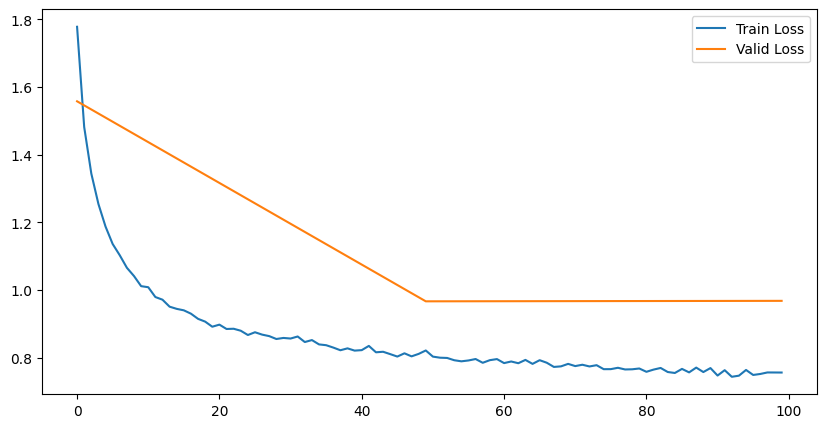

In [63]:
trainer.plot_losses()

### Evaluation

In [64]:
after_training_acc = trainer.accuracy(Xval, yval)
print(f'Accuracy after training: {after_training_acc:.2%}')

Accuracy after training: 69.68%


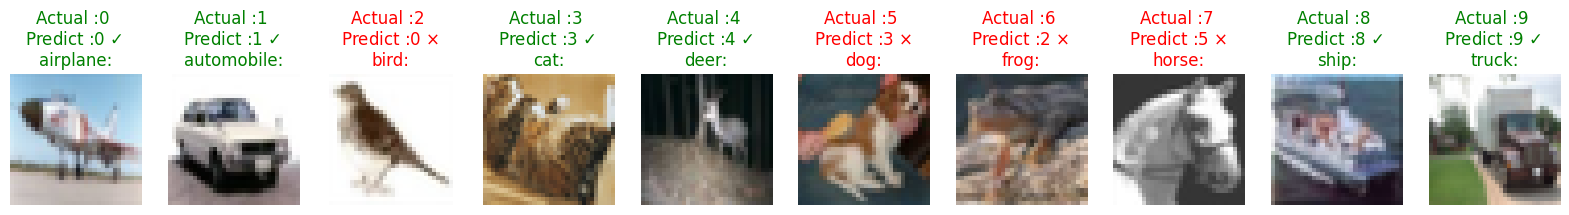

In [65]:
compare_with_images(model, Xval, yval)

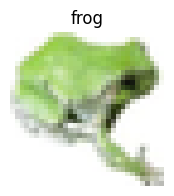

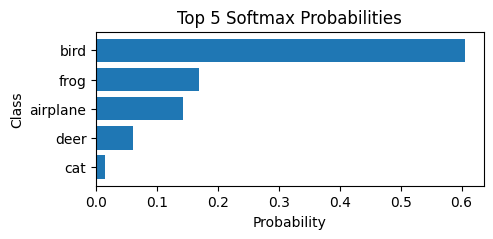

In [66]:
plot_img(Xb[:1] , yb[:1])
plot_probs(torch.softmax(model(Xb[:1]) , dim = 1)[0])

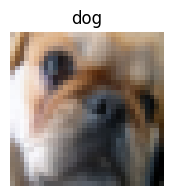

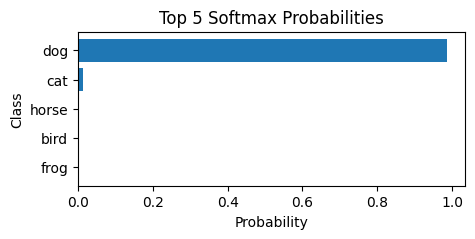

In [67]:
plot_img(Xb[1:2] , yb[1:2])
plot_probs(torch.softmax(model(Xb[1:2]) , dim = 1)[0])

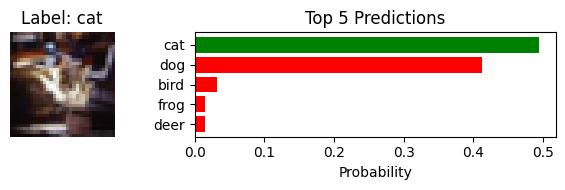

In [68]:
plot_img_with_probs(Xval, yval_enc, model)

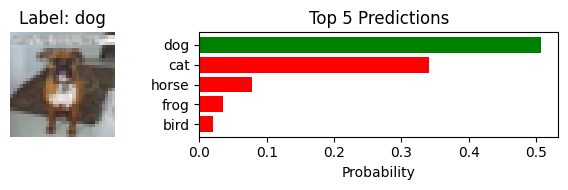

In [69]:
plot_img_with_probs(Xval, yval_enc, model)

### Save Model

In [70]:
models_dir = './saved_models/'
folder_name = 'karpathynet_cifar10'

if not os.path.exists(models_dir + folder_name):
    os.makedirs(models_dir + folder_name)

save_path = models_dir + folder_name + f'/{device}_100ep_model_checkpoint.pth'

save_checkpoint(model, optimiser, number_of_epochs, trainer.logs, filename=save_path)

[+] Checkpoint saved at epoch 100


### Load Model

In [71]:
epoch, logs = load_checkpoint(model, optimiser, filename=save_path)

[+] Checkpoint loaded. Resuming from epoch 100


### Test Accuracy Report

In [72]:
Test_Accuracy = trainer.accuracy(Xte, yte)
print(f'Accuracy after training: {Test_Accuracy:.2%}')

Accuracy after training: 68.42%


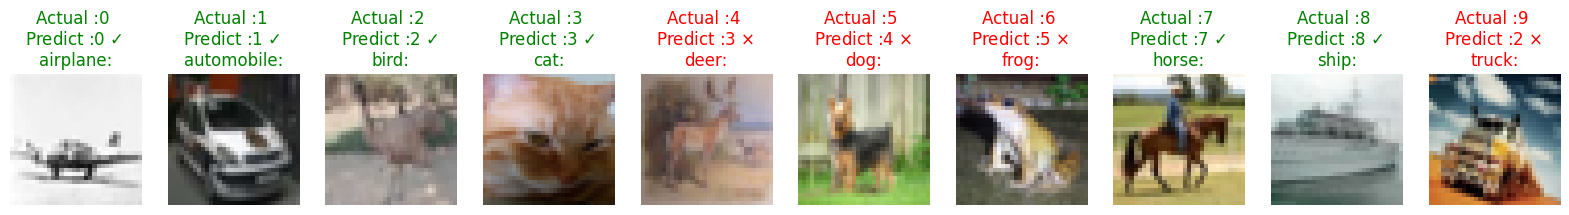

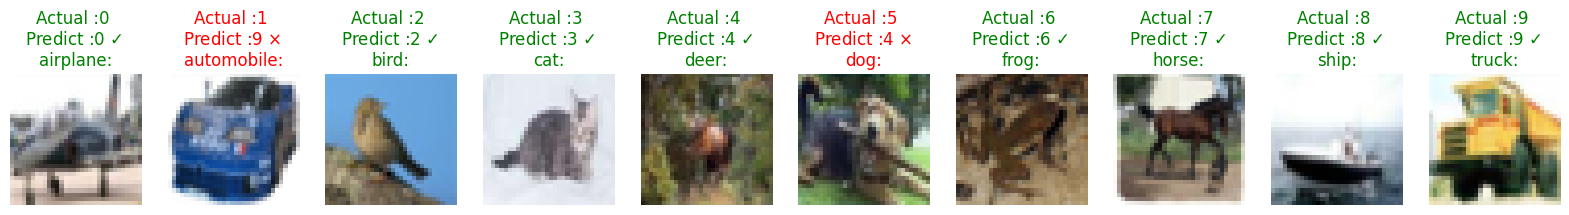

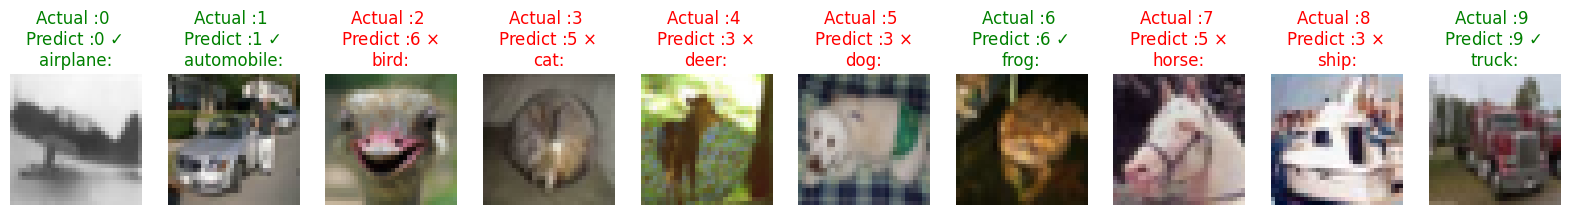

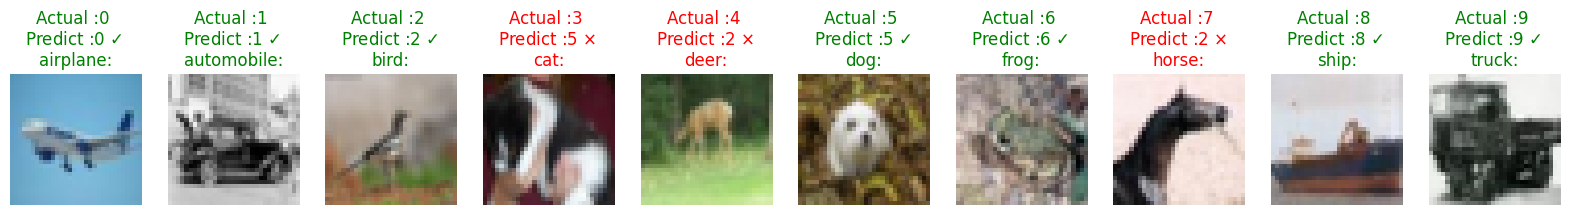

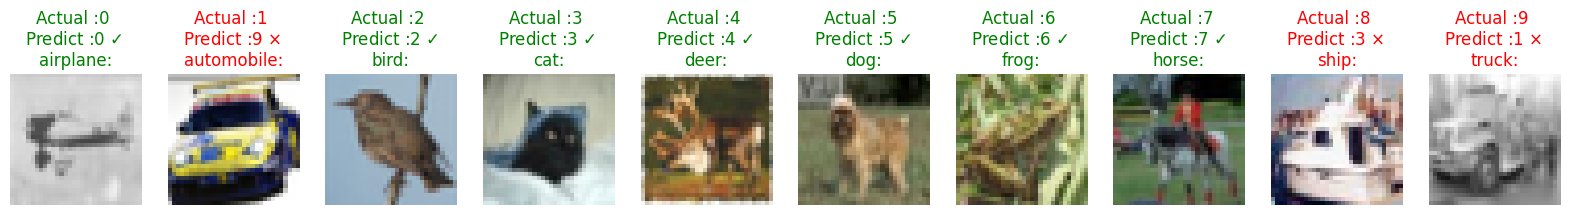

In [73]:
compare_with_images(model, Xte, yte)
compare_with_images(model, Xte, yte)
compare_with_images(model, Xte, yte)
compare_with_images(model, Xte, yte)
compare_with_images(model, Xte, yte)

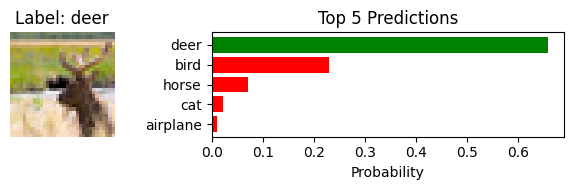

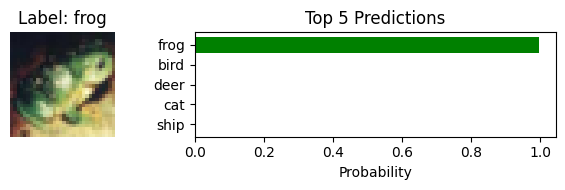

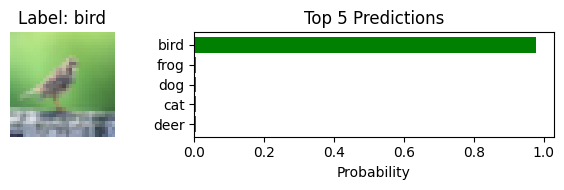

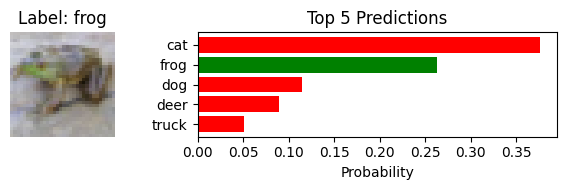

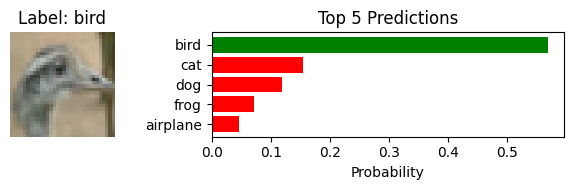

In [74]:
plot_img_with_probs(Xte, yte_enc, model)
plot_img_with_probs(Xte, yte_enc, model)
plot_img_with_probs(Xte, yte_enc, model)
plot_img_with_probs(Xte, yte_enc, model)
plot_img_with_probs(Xte, yte_enc, model)